In [164]:
import numpy as np
import matplotlib.pyplot as plt
import bilby
import pandas as pd
import scipy
import joblib
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
import astropy
import matplotlib.patches as mpatches
from itertools import product
from scipy import stats
from matplotlib.patches import Ellipse
from scipy.stats import gaussian_kde
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset
import arviz as az
import matplotlib
import matplotlib.lines as mlines


In [21]:
SMALL_SIZE = 15+5
MEDIUM_SIZE = 20+5
BIGGER_SIZE = 25+5

plt.rc('font', size=SMALL_SIZE)
plt.rc('axes', titlesize=SMALL_SIZE)
plt.rc('axes', labelsize=MEDIUM_SIZE)
plt.rc('xtick', labelsize=SMALL_SIZE)
plt.rc('ytick', labelsize=SMALL_SIZE)
plt.rc('legend', fontsize=SMALL_SIZE)
plt.rc('figure', titlesize=BIGGER_SIZE)

In [3]:
catalog = pd.read_csv('data/mock_galaxy_catalog.txt', delim_whitespace=True, names=['name', 'ra', 'dec', 'z'], skiprows=1)
catalog_dict = {col: catalog[col].values for col in catalog.columns}
HL_samples = joblib.load('output/equal_samples_HL.pkl')
HLV_samples = joblib.load('output/equal_samples_HLV.pkl')

/tmp/ipykernel_1334/4054183599.py:1: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  catalog = pd.read_csv('data/mock_galaxy_catalog.txt', delim_whitespace=True, names=['name', 'ra', 'dec', 'z'], skiprows=1)


In [5]:
detector_delays, measured_delays, sigmas, prob, masks, combined, numeric_masks, numeric_combined = joblib.load('output/matched_filtering.pkl')

In [205]:
def plot_maps(masks, combined, equal_samples):
    for i, (samples, title) in enumerate(zip(equal_samples, ['HL', 'HLV'])):
        ra = np.linspace(0, 2*np.pi, 1000)
        dec = np.linspace(-np.pi/2, np.pi/2, 1000)
        RA, DEC = np.meshgrid(ra, dec)

        ra_samples = samples[:, 0]
        dec_samples = samples[:, 1]
        ra_median = np.median(ra_samples)
        dec_median = np.median(dec_samples)
        ra_hpd = az.hdi(ra_samples, hdi_prob=0.68)
        dec_hpd = az.hdi(dec_samples, hdi_prob=0.68)

        fig = plt.figure(figsize=(30, 8))
        gs = fig.add_gridspec(2, 3, width_ratios=[4, 1, 10], height_ratios=[1, 4], wspace=0.01, hspace=0.05)
        
        ax_hist = fig.add_subplot(gs[1, 0])
        h = ax_hist.hist2d(ra_samples, dec_samples, bins=100, cmap='Oranges')
        ax_hist.set_xlabel('RA (rad)')
        ax_hist.set_ylabel('Dec (rad)')
        ax_hist.axvline(ra_median, color='k', linestyle=':')
        ax_hist.axhline(dec_median, color='k', linestyle=':')
        ax_hist.grid(True)

        ax_ra = fig.add_subplot(gs[0, 0], sharex=ax_hist)
        ax_ra.hist(ra_samples, bins=100, color='grey', density=True)
        # ax_ra.set_ylabel('Density')
        ax_ra.axvline(x=ra_median, color='k', linestyle=':', label='Median')
        ax_ra.tick_params(labelbottom=False)
        ax_ra.axvspan(ra_hpd[0], ra_hpd[1], color='indigo', alpha=0.3, label='68% CI')
        ax_ra.set_xticklabels([])

        ax_dec = fig.add_subplot(gs[1, 1], sharey=ax_hist)
        ax_dec.hist(dec_samples, bins=100, color='grey', density=True, orientation='horizontal')
        # ax_dec.set_xlabel('Density')
        ax_dec.axhline(y=dec_median, color='k', linestyle=':')
        ax_dec.tick_params(labelleft=False)
        ax_dec.set_yticklabels([])
        ax_dec.axhspan(dec_hpd[0], dec_hpd[1], color='indigo', alpha=0.3)
        ax_dec.grid(True)

        ax_moll = fig.add_subplot(gs[:, 2], projection='mollweide')
        ax_moll.grid(True)
        ax_moll.set_xlabel('RA (rad)')
        ax_moll.set_ylabel('Dec (rad)')
        ax_moll.scatter(ra_samples, dec_samples, s=1, color='orange', alpha=1, label='Bayesian samples')
        if i == 0:
            ax_moll.contour(RA, DEC, masks.T[0].T,  colors='grey', linestyles='--', lw=2, zorder=1, label='Matched filtering contour')
        else:
            ax_moll.contour(RA, DEC, combined, colors='grey', linestyles='--', lw=2, zorder=1, label='Matched filtering contour')        

        handles1, labels1 = ax_ra.get_legend_handles_labels()
        handles2, labels2 = ax_moll.get_legend_handles_labels()

        all_handles = handles1 + handles2
        all_labels = labels1 + labels2
        custom_handles = []
        for handle, label in zip(all_handles, all_labels):
            if label == 'Bayesian samples':
                # For scatter, create a custom Line2D with larger marker
                custom_handle = mlines.Line2D([], [], color='orange', marker='o', linestyle='None',
                                            markersize=10, label=label)
            elif label == 'Matched filtering contour':
                # For contour line
                custom_handle = mlines.Line2D([], [], color='grey', linestyle='--', lw=2, label=label)
            elif label == 'Median':
                custom_handle = mlines.Line2D([], [], color='k', linestyle=':', label=label)
            elif label == '68% CI':
                custom_handle = mlines.Line2D([], [], color='indigo', alpha=0.3, lw=6, label=label)
            else:
                continue  # skip unknowns or add other cases as needed
            custom_handles.append(custom_handle)
        custom_handle = mlines.Line2D([], [], color='grey', linestyle='--', lw=2, label='Matched filtering contour')
        custom_handles.append(custom_handle)

        all_labels.append('Matched filtering contour')
        
        fig.legend(custom_handles, all_labels, ncols=4, bbox_to_anchor=[0.72,0])
        plt.savefig(f'figures/radec_posterior_{title}.png', bbox_inches='tight', dpi=300)

    fig, ax = plt.subplots(1, 2, figsize=(20,6), sharey=True)
    for i, sample in enumerate(equal_samples):
        dl_samples = samples[:, 4]
        dl_median = np.median(dl_samples)
        dl_hpd = az.hdi(dl_samples, hdi_prob=0.68)
        
        ax[i].hist(dl_samples, bins=100, color='grey', density=True)
        ax[i].axvline(x=dl_median, color='k', linestyle=':' if i==0 else '-.', label=fr'$D_L = {dl_median:.2f}^{{+{dl_hpd[1]-dl_median:.2f}}}_{{-{dl_median-dl_hpd[0]:.2f}}}$ Gpc')
        ax[i].axvspan(dl_hpd[0], dl_hpd[1], color='indigo', alpha=0.5, label='68% CI' if i==0 else None)
        ax[i].grid(True)
        ax[i].set_xlabel('Luminosity distance $D_L$ (Gpc)')
        
    fig.legend(ncols=3, bbox_to_anchor=[0.75,0])

    ax[0].set_ylabel('Density')

    plt.savefig('figures/dl_posterior.png', bbox_inches='tight', dpi=300)
    plt.show()


/tmp/ipykernel_1334/442856049.py:48: UserWarning: The following kwargs were not used by contour: 'lw', 'label'
  ax_moll.contour(RA, DEC, masks.T[0].T,  colors='grey', linestyles='--', lw=2, zorder=1, label='Matched filtering contour')
/tmp/ipykernel_1334/442856049.py:50: UserWarning: The following kwargs were not used by contour: 'lw', 'label'
  ax_moll.contour(RA, DEC, combined, colors='grey', linestyles='--', lw=2, zorder=1, label='Matched filtering contour')


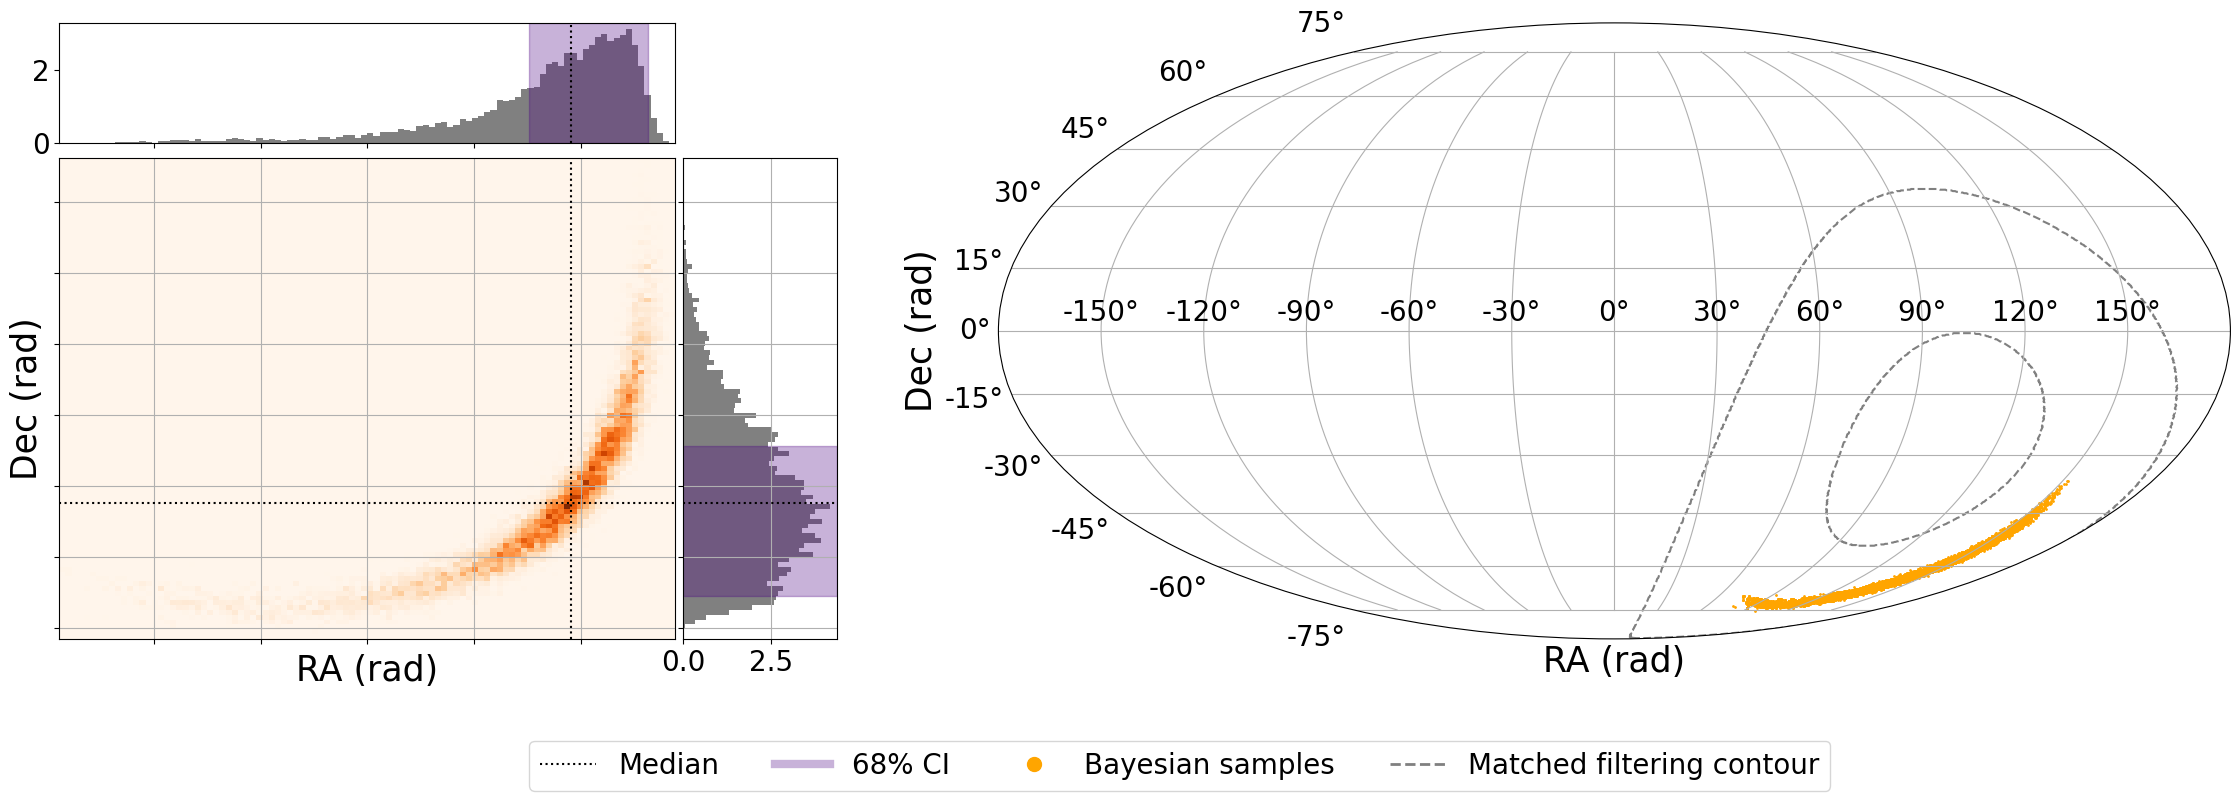

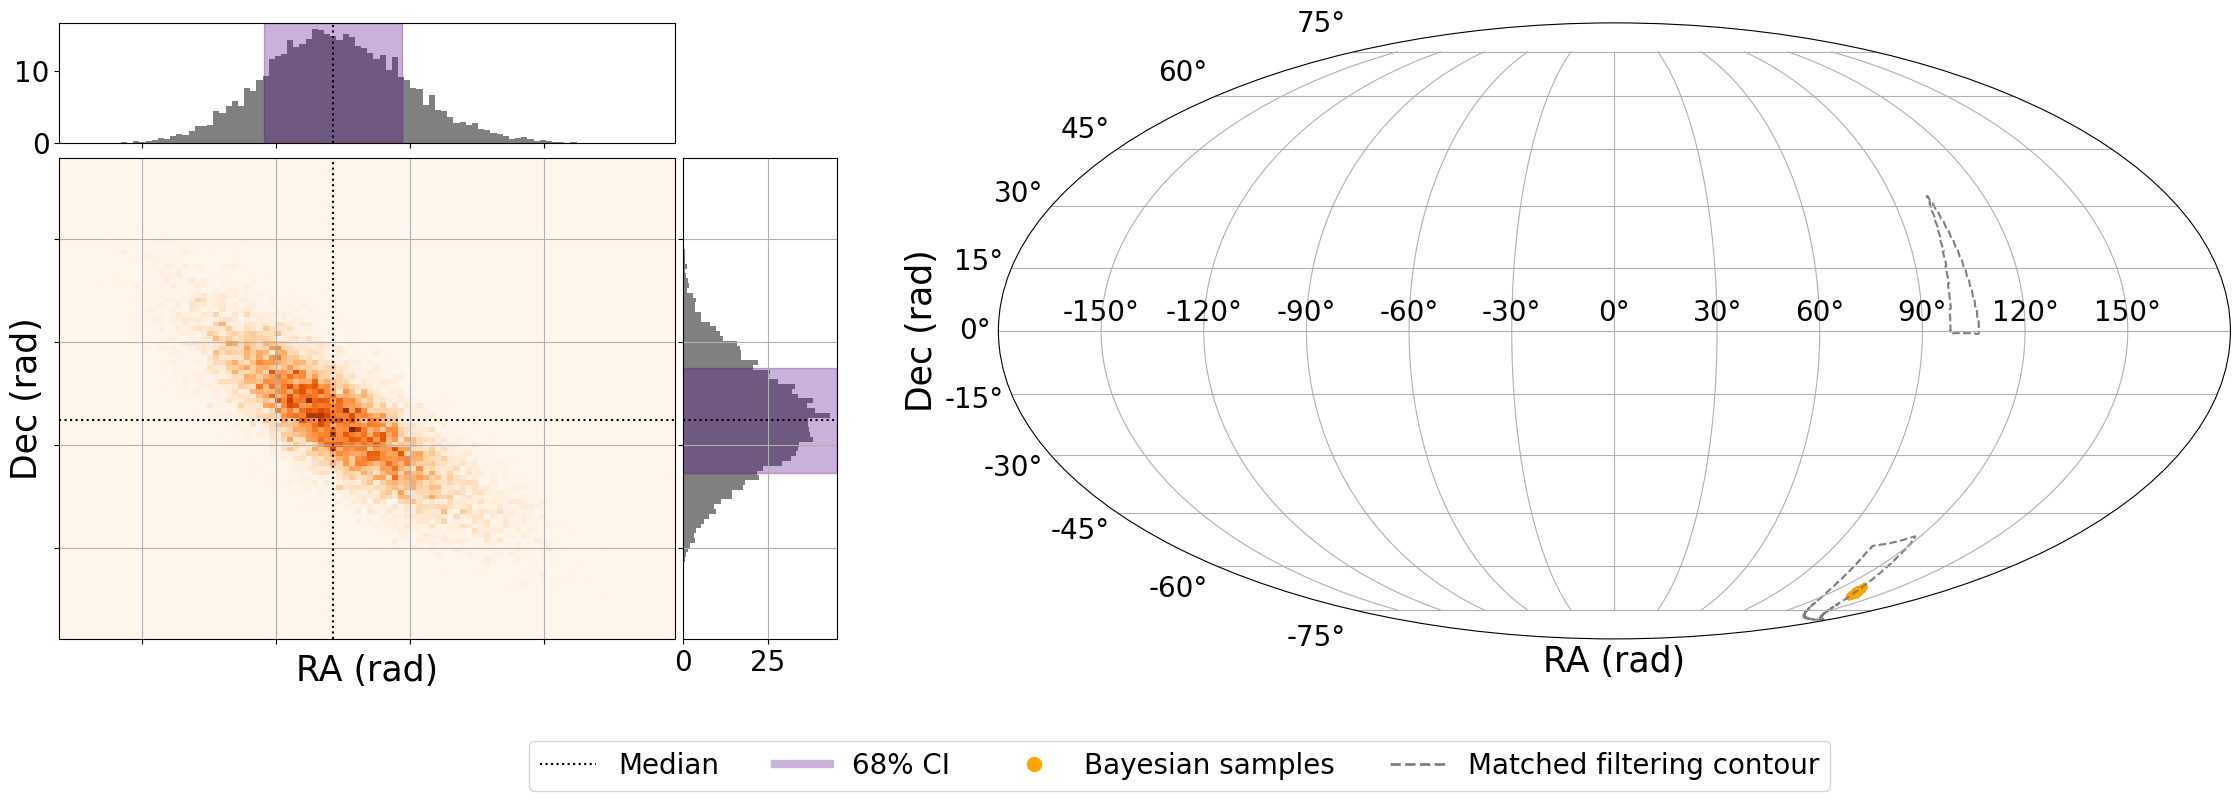

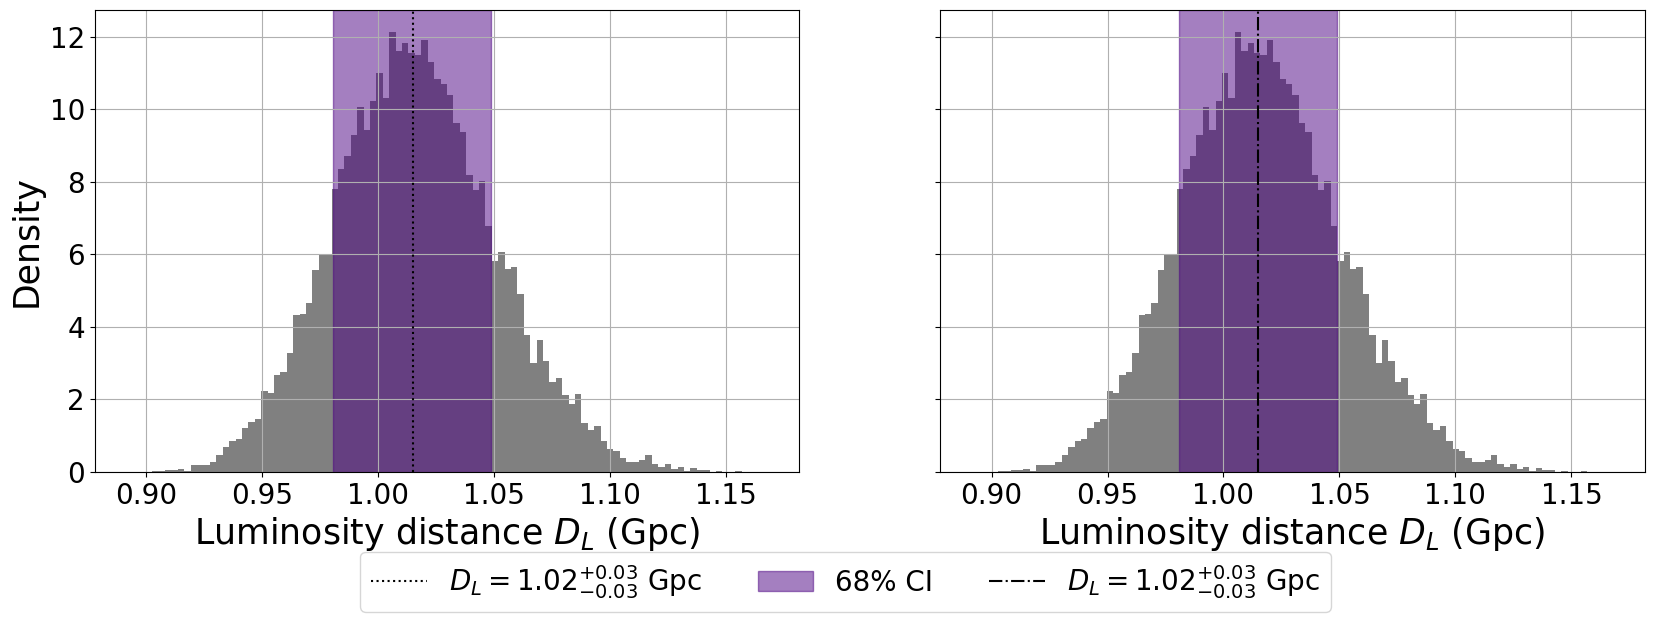

In [206]:
plot_maps(masks, combined, [HL_samples, HLV_samples])

In [207]:
def get_kde(samples, catalog_dict, labels=['HL', 'HLV']):

    matches = []
    thresholds = []
    densities = []
    RA = []
    DEC = []

    for sample, label in zip(samples, labels):
        kde = gaussian_kde(np.vstack([sample[:,0], sample[:,1]]))

        # Grid for evaluation
        ra_grid = np.linspace(sample[:,0].min()-0.1, sample[:,0].max()+0.1, 200)
        dec_grid = np.linspace(sample[:,1].min()-0.1, sample[:,1].max()+0.1, 200)
        RA_grid, DEC_grid = np.meshgrid(ra_grid, dec_grid)
        positions = np.vstack([RA_grid.ravel(), DEC_grid.ravel()])
        density = kde(positions).reshape(RA_grid.shape)

        # Sort densities descending, compute cumulative sum
        sorted_density = np.sort(density.ravel())[::-1]
        cumulative = np.cumsum(sorted_density)
        cumulative /= cumulative[-1]  # normalize to 1

        # Find density threshold for 90% credible region
        threshold_idx = np.searchsorted(cumulative, 0.9)
        density_threshold = sorted_density[threshold_idx]

        flat = density.flatten()
        idx = np.argsort(flat)[::-1]
        cumulative_density = np.cumsum(flat[idx])
        cumulative_density /= cumulative_density[-1] 
        level = flat[idx][np.searchsorted(cumulative_density, 0.9)]

        gal_dens = kde(np.vstack([catalog_dict['ra'], catalog_dict['dec']]))
        inside = gal_dens >= level

        # Filter the catalog
        matched_catalog = np.column_stack((
            catalog_dict['name'][inside],
            catalog_dict['ra'][inside],
            catalog_dict['dec'][inside],
            catalog_dict['z'][inside]
        ))
        matched_df = pd.DataFrame(matched_catalog, columns=['name', 'ra', 'dec', 'z'])

        print(f"\nCross-matching {label} samples with the catalog...")
        print(matched_df)
        matches.append(matched_df)
        thresholds.append(density_threshold)
        densities.append(density)
        RA.append(RA_grid)
        DEC.append(DEC_grid)

    fig, ax = plt.subplots(1, 2, figsize=(25, 10))
    for i, (ra_grid, dec_grid, density, threshold, label, df, sample) in enumerate(zip(RA, DEC, densities, thresholds, labels, matches, samples)):
        ax[i].contour(ra_grid, dec_grid, density, levels=[threshold], linewidths=1)
        ax[i].scatter(catalog_dict['ra'], catalog_dict['dec'], s=15, color='gray', label='Catalog')
        ax[i].scatter(sample[:,0], sample[:,1], s=1, color='red', alpha=0.5, label=f'{label} samples')
        ax[i].scatter(df['ra'], df['dec'], s=15, color='blue', label=f'{label} identified stars')
        ax[i].set_xlabel('RA (rad)')
        ax[i].set_ylabel('Dec (rad)')
        ax[i].grid()
    
        all_handles, all_labels = ax[i].get_legend_handles_labels()

        custom_handles = []
        for handle, label in zip(all_handles, all_labels):
            if label == 'Catalog':
                # For scatter, create a custom Line2D with larger marker
                custom_handle = mlines.Line2D([], [], color='gray', marker='o', linestyle='None',
                                            markersize=10, label=label)
            elif label == 'HL samples' or label=='HLV samples':
                # For contour line
                custom_handle = mlines.Line2D([], [], color='red', marker='o', linestyle='None',
                                            markersize=10, label=label)
            elif label == 'HL identified stars' or label=='HLV identified stars':
                custom_handle = mlines.Line2D([], [], color='blue', marker='o', linestyle='None',
                                            markersize=10, label=label)
            else:
                continue  # skip unknowns or add other cases as needed
            custom_handles.append(custom_handle)
        ax[i].legend(custom_handles, all_labels)

    axins = zoomed_inset_axes(ax[1], zoom=10)  # adjust zoom factor and location as needed

    # Repeat the same plotting commands for inset
    axins.contour(RA[1], DEC[1], densities[1], levels=[thresholds[1]], colors='black', linewidths=1)
    axins.scatter(catalog_dict['ra'], catalog_dict['dec'], s=15, color='gray')
    axins.scatter(samples[1][:, 0], samples[1][:, 1], s=1, color='red', alpha=0.5)
    axins.scatter(matches[1]['ra'], matches[1]['dec'], s=15, color='blue')

    # Set inset zoom limits (choose RA/Dec zoom region)
    x1, x2 = 2.18, 2.45  # RA range (rad)
    y1, y2 = -1.12, -1.25  # Dec range (rad)
    axins.set_xlim(x1, x2)
    axins.set_ylim(y2, y1)

    axins.set_xticks([])
    axins.set_yticks([])
    axins.set_xticklabels([])
    axins.set_yticklabels([])

    mark_inset(ax[1], axins, loc1=2, loc2=4, fc="none", ec="black")


    return matches


Cross-matching HL samples with the catalog...
          name     ra    dec      z
0  MGC+JGS5HZS  2.543 -0.969  0.797
1  MGC+JN7U119  2.375 -1.211  0.226

Cross-matching HLV samples with the catalog...
          name     ra    dec      z
0  MGC+JN7U119  2.375 -1.211  0.226


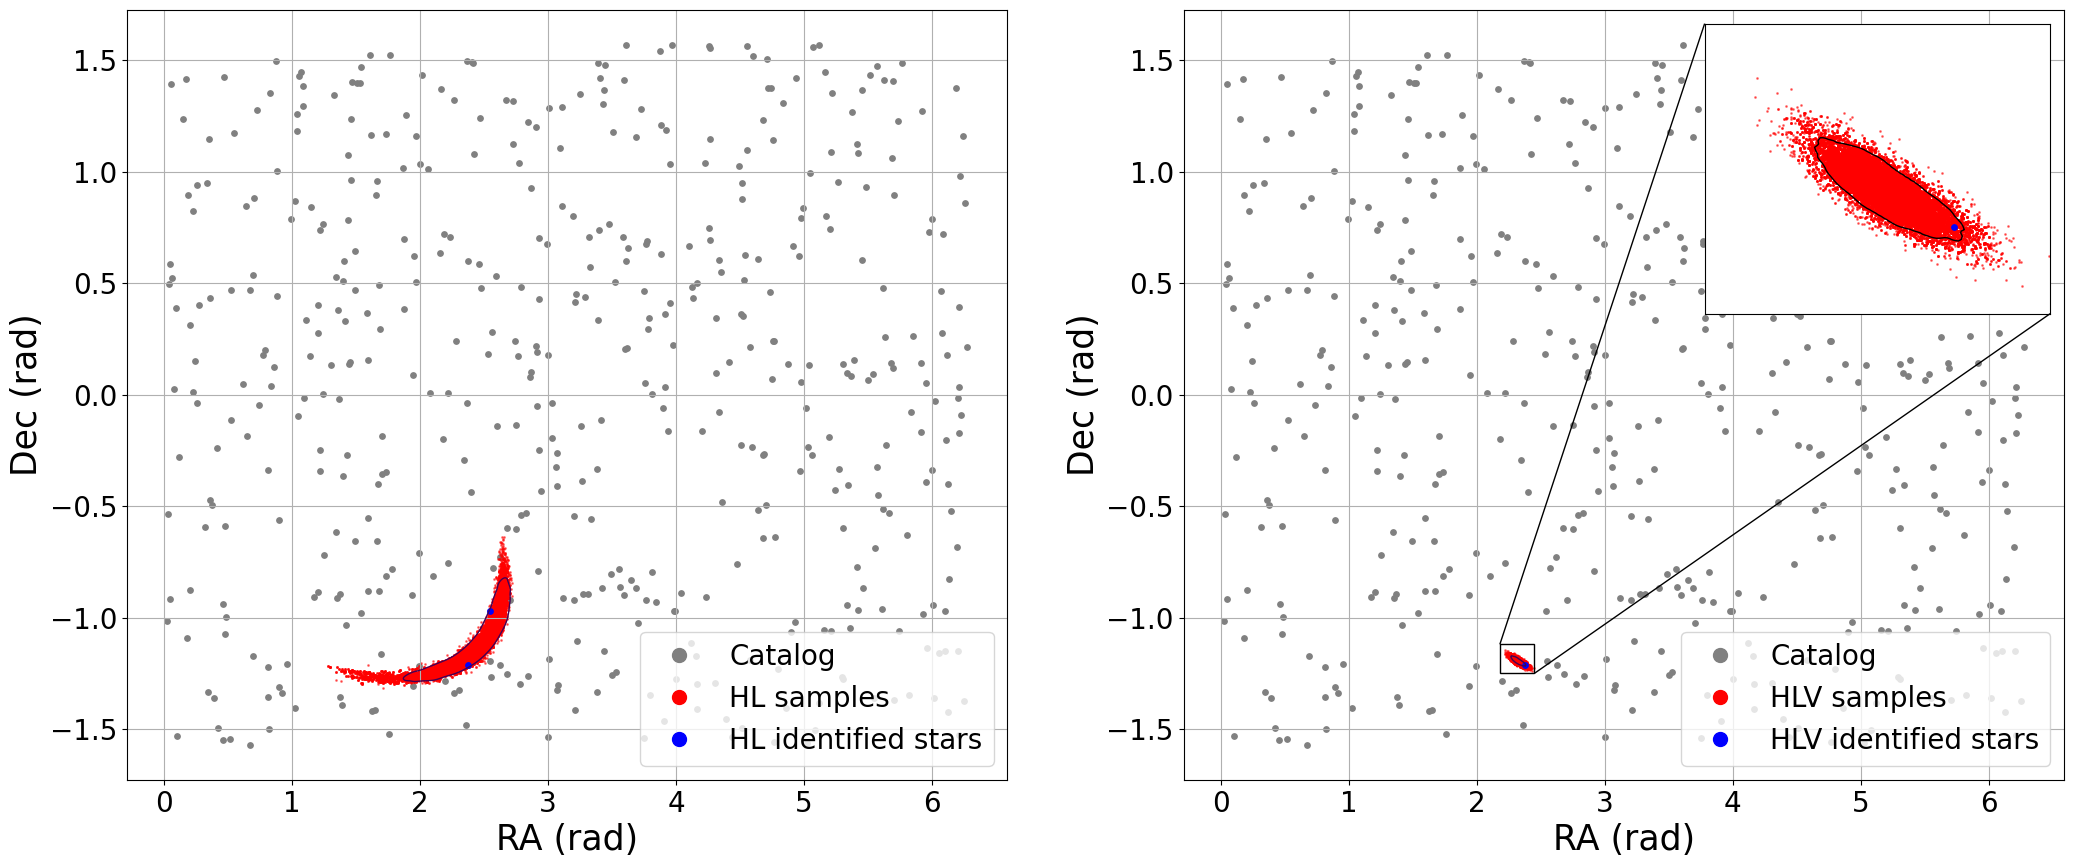

In [208]:
dfs = get_kde([HL_samples, HLV_samples], catalog_dict)

In [229]:
def measure_hubble(samples, df):
    dl_samples = samples[:,4]*1e3 #Gpc to Mpc
    dl_median = np.median(dl_samples)
    dl_hpd = az.hdi(dl_samples, hdi_prob=0.68)
    z = df['z'].astype(float).values[0]
    v = z * 2.99792458e5  # Convert redshift to velocity in km/s
    hubble = v/dl_median  # Convert to km/s/Mpc
    hubble_err = [v/dl_median * (dl_median-dl_hpd[0])/dl_median, v/dl_median * (dl_hpd[1]-dl_median)/dl_median]
    print(f"Hubble constant: {hubble:.2f} km/s/Mpc + {hubble_err[0]:.2f} - {hubble_err[1]:.2f} km/s/Mpc")

In [230]:
measure_hubble(HLV_samples, dfs[1])

Hubble constant: 66.75 km/s/Mpc + 2.26 - 2.22 km/s/Mpc
